In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from datetime import datetime
import warnings
from collections import defaultdict
import os

%matplotlib inline
warnings.filterwarnings('ignore')

# Output directory
OUTPUT_DIR = '../Outputs/country_clusters/'
COUNTRY_DATA_PATH = '../Data/country_data/'

In [2]:
# Load ETF returns for Equities
equity_etfs = pd.read_csv(COUNTRY_DATA_PATH + 'ETF_adj_close.csv', index_col=0)
equity_etfs.index = pd.to_datetime(equity_etfs.index)

In [3]:
# Read country sovereign bond data
ticker = pd.read_excel(os.path.join(COUNTRY_DATA_PATH, 'ice_bofa_sovereign_indices_data.xlsx'), sheet_name='ticker mapping')
ticker['Country'] = ticker['Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))
ticker['Index Full Name'] = ticker['Index'] + ' Index'
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

bnd_idx_price = pd.read_excel(os.path.join(COUNTRY_DATA_PATH, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)
bnd_idx_price.drop(index=[0, 1], inplace=True)
bnd_idx_price.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
bnd_idx_price.set_index('Date', inplace=True)
bnd_idx_price = bnd_idx_price.astype('float')
bnd_idx_price_weekly = bnd_idx_price.resample('W').last()

bnd_idx_price_weekly.rename(columns=ticker_dict, inplace=True)

# Fixed Income Country Clustering

## 1. Clean historical data
Gather country sovereign bond indices and convert weekly indices to log-returns. Drop country if returns contain NaN's or mostly zero's.

In [4]:
# Set start date
start_date = '2003-10-01'
bnd_weekly_prices_df = bnd_idx_price_weekly[bnd_idx_price_weekly.index>start_date]
bnd_weekly_prices_df = bnd_weekly_prices_df.dropna(axis=1)
bnd_w_log_ret = np.log(bnd_weekly_prices_df).diff().iloc[1:]

# Drop columns if it contains nan's
bnd_w_log_ret = bnd_w_log_ret.dropna(axis=1, how='any')
# Drop columns if it contains 50%+ 0's
bnd_w_log_ret = bnd_w_log_ret.loc[:, (bnd_w_log_ret==0).mean() < .5]

normalized_bnd_ret = (bnd_w_log_ret-bnd_w_log_ret.mean())/bnd_w_log_ret.std()
normalized_bnd_ret = normalized_bnd_ret.dropna(axis=1)

## 2. Generate hierarchical clustering
Compute hierarchical clustering based on Ward's method based on weekly bond returns.

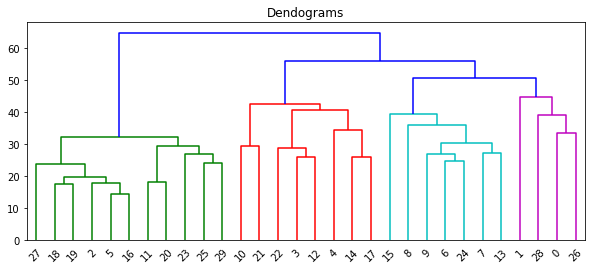

In [5]:
# First check for the entire sample
plt.figure(figsize=(10, 4))
plt.title("Dendograms")
dend_FI = shc.dendrogram(shc.linkage(normalized_bnd_ret.T, method='ward'))

In [6]:
fi_cluster_full = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
fi_cluster_full.fit_predict(normalized_bnd_ret.T)

# Generate dataframe
fi_cluster_full_df = pd.DataFrame({'Countries': list(normalized_bnd_ret), 'cluster_label': fi_cluster_full.labels_})
fi_cluster_full_df = fi_cluster_full_df.sort_values(by=['cluster_label'], ascending=True).reset_index(drop=True)

In [20]:
fi_cluster_full_df.head()

,Countries,cluster_label
0,Bulgaria,0
1,Bolivia,0
2,Ukraine,0
3,Venezuela,0
4,El Salvador,1


In [8]:
fi_cluster_full_df.to_pickle(OUTPUT_DIR + 'clusters_bond_idx_ret_full.pkl')

## 3. (Optional) Generate "expanding window" clusters
Using an expanding window approach, generate different clusters for each year. 
* Window size = 4 years to start. 
* **NOTES:** Kept the code here if we need it in the future, but I found that country clusters tend to stay the same except during the crisis periods. Also, if we take a subsample of the time series vs. another, we'd get similar clusters. Clusters are very sensitive to changes in returns - our goal is not to predict returns, but to figure out which countries are similar vs. dis-similar beyond basic economic fundamentals.

In [9]:
# Inspect cluster sizes for each year based on dendograms
# def plot_dendograms(df, K = 4):
#     # Compute different clusters by year
#     start_year = df.index.year.unique()[0]
#     end_year = df.index.year.unique()[-1]
#     num_years = end_year - start_year
    
#     for ii in range(num_years - K):
#         new_df = df[(df.index.year >= (start_year + ii)) & (df.index.year <= (ii + start_year + K))]
#         predict_year = new_df.index.year.unique()[-1] + 1
        
#         # First check for the entire sample
#         plt.figure(figsize=(10, 4))
#         plt.title("Dendograms: " + str(predict_year))
#         dend_FI = shc.dendrogram(shc.linkage(new_df.T, method='ward'))

In [10]:
# plot_dendograms(normalized_bnd_ret)

# Equity Returns & Clustering

## 1. Generate hierarchical clustering
Perform hierarchical clustering based on country equity returns. Create a dendrogram that illustrate the hierarchical clustering

In [11]:
equity_etfs_w = equity_etfs.resample('W').last()
equity_rets_w = np.log(equity_etfs_w).diff()
equity_rets_w = equity_rets_w.dropna()

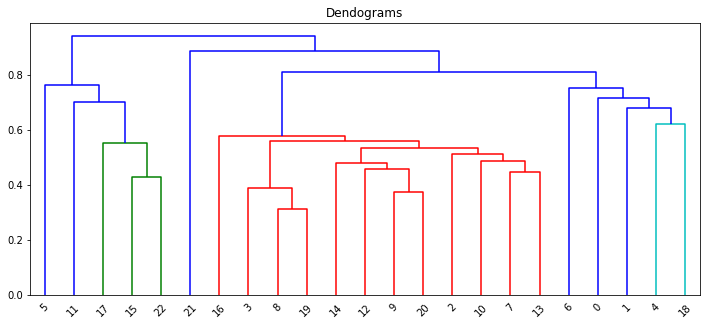

In [12]:
plt.figure(figsize=(12, 5))
plt.title("Dendograms")
dend_equity = shc.dendrogram(shc.linkage(equity_rets_w.T, method='ward'))

In [18]:
cluster_ret_etf = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster_ret_etf.fit_predict(equity_rets_w.T)

# Match countries to clusters, income status, geography
cluster_ret_etf_df = pd.DataFrame({'Countries': list(equity_rets_w), 'cluster_label': cluster_ret_etf.labels_})
cluster_ret_etf_df = cluster_ret_etf_df.sort_values(by=['cluster_label'], ascending=True).reset_index(drop=True)
cluster_ret_etf_df.head()

,Countries,cluster_label
0,Pakistan,0
1,Saudi Arabia,0
2,Qatar,0
3,Egypt,0
4,United Arab Emirates,0


In [14]:
cluster_ret_etf_df.to_pickle(OUTPUT_DIR + 'clusters_equity_etf_full.pkl')